Current working directory is /home/klam/seq_artifacts

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os.path
#import sklearn as sk
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import get_metrics
import time

In [2]:
srr_names = ['ERR1831349',
             'ERR1831346',
             'ERR1831347',
             'ERR1831348',
             'ERR1831350',
             'ERR1831351',
             'ERR1831352',
             'ERR1831353',
             'ERR1905889',
             'ERR1905890',
             'SRR14724463',
             'SRR14724473',
             'SRR14724483',
             'SRR14724493', 
             'SRR14724503',
             'SRR14724513',
             'SRR2106342',
             'SRR2106344',
             'DRR189730',
             'DRR189731',
             'DRR189732']

In [3]:
# Convert SRR VCF files into a pandas df -- Extract flanks and get metrics
# if pkl file exists then we already got metrics and converted to pkl
srr_snv_metrics_dfs = []
srr_snv_metrics_names = []
for srr_name in srr_names:
    pkl_path = f'results/outputs/pickle/{srr_name}_snv_metrics.pkl'
    if os.path.exists(pkl_path):
        continue
    else:
        srr_vcf = f'results/outputs/bedtools/{srr_name}_SRA_variants_exome_intersection.vcf'
        srr_df = get_metrics.main(srr_vcf).set_index(["CHROM", "POS"]) # makes index unique based on CHROM and POS
        # Only select SNVs from the SRR datasets
        srr_snv_df = get_metrics.filter_for_snvs(srr_df)
        srr_snv_metrics_dfs.append(srr_snv_df)
        srr_snv_metrics_names.append(srr_name)

# Save all srr_snv_metrics_dfs as a pickle file for easier loading in later if there are dfs to serialize
if len(srr_snv_metrics_dfs) != 0:
    for srr_name, srr_snv_metric_df in zip(srr_snv_metrics_names, srr_snv_metrics_dfs):
        pkl_path = f'results/outputs/pickle/{srr_name}_snv_metrics.pkl'
        srr_snv_metric_df.to_pickle(pkl_path) 

In [4]:
# Read in the pkl SRR SNV metrics df files we created in the previous cell   
srr_snv_dfs = []
for srr_name in srr_names:
    pkl_path = f'results/outputs/pickle/{srr_name}_snv_metrics.pkl'
    df = pd.read_pickle(pkl_path)
    # downcast integer and float dtypes to save memory
    #float_cols = df.select_dtypes('int').columns
    #int_cols = df.select_dtypes('float').columns
    #df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    #df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    srr_snv_dfs.append(df)    

In [5]:
srr_snv_dfs[0].head()
#dtypes: float64(8), int64(524), object(11)

REF ALT      AF    HIAF HICNT  VD   SN   ADJAF VARBIAS  \
CHROM POS                                                             
chr1  826893   G   A       1  1.0000    40  40   80    0.05    6:34   
      941119   A   G       1  1.0000     8   8   16   0.375     6:2   
      944168   G   T  0.0513  0.0526     2   2    4       0     1:1   
      944858   A   G       1  1.0000    67  67  134  0.0149   40:27   
      946247   G   A    0.95  1.0000    19  19   38       0    17:2   

                              LSEQ  ...  R_TATG  R_TTAA  R_GTAA  R_TATC  \
CHROM POS                           ...                                   
chr1  826893  GAAGAAGCCCCTGCCAAGGA  ...       0       0       0       0   
      941119  GAGGGCGCATAGCCGGGGGG  ...       0       0       0       0   
      944168  TGTTGAGGTTGCCGGGGGTA  ...       0       0       0       0   
      944858  ATCAGGAAGAAGCCAGCCTT  ...       0       0       0       0   
      946247  GTGGCTGTAGTACAAGGTCA  ...       0       0       0       0   

              R_HOMO_POLY_A  R_HOMO_POLY_T  R_HOMO_POLY_G  R_HOMO_POLY_C  \
CHROM POS                                                                  
chr1  826893              0              0              3              3   
      941119              0              0              0              5   
      944168              3              0              4              0   
      944858              0              0              0              0   
      946247              0              0              3              4   

              R_PALINDROME  R_HAIRPIN  
CHROM POS                              
chr1  826893             0          0  
      941119             0          0  
      944168             4          0  
      944858             4          0  
      946247             6          0  

[5 rows x 543 columns]

In [6]:
srr_snv_dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40434 entries, ('chr1', '826893') to ('chrX', '143884366')
Columns: 543 entries, REF to R_HAIRPIN
dtypes: float64(8), int64(524), object(11)
memory usage: 168.1+ MB


In [7]:
# SAVE MEMORY RUN THIS
# took 13 min to downcast!!!
#for srr_snv_df in srr_snv_dfs:
#    float_cols = srr_snv_df.select_dtypes('float').columns
#    int_cols = srr_snv_df.select_dtypes('int').columns
#    srr_snv_df[float_cols] = srr_snv_df[float_cols].apply(pd.to_numeric, downcast='float')
#    srr_snv_df[int_cols] = srr_snv_df[int_cols].apply(pd.to_numeric, downcast='integer')

In [8]:
# Convert GIAB VCF file into a pandas df 
giab_snv_dfs = []
for srr_name in srr_names: 
    giab_vcf = f'results/outputs/bedtools/{srr_name}_GIAB_variants_exome_intersection.vcf'
    giab_df = get_metrics.vcf_to_df(giab_vcf).set_index(["CHROM", "POS"]) # makes index unique based on CHROM and POS
    # Only select SNVs from the GIAB datasets
    giab_snv_df1 = get_metrics.filter_for_snvs(giab_df)
    giab_snv_df2 = get_metrics.snp_freq_not1(giab_df)
    giab_snv_df = pd.concat([giab_snv_df1, giab_snv_df2])
    giab_snv_dfs.append(giab_snv_df)

In [9]:
# Match each SRR SNV DF with GIAB SNV DF using zip() then merge them into a single DF
joined_dfs = []
for srr_snv_df, giab_snv_df in zip(srr_snv_dfs, giab_snv_dfs):
    joined_df = get_metrics.join_datasets(srr_snv_df, giab_snv_df)
    joined_dfs.append(joined_df)

In [10]:
# Count the number of artifacts per case

# Case 1: GIAB and SRR contain the same variant at the same locus is considered true variant (not artifact)
# Case 2: GIAB contains a variant and SRR contains a different variant at the same locus (artifact)
# Case 3: GIAB contains a variant, but SRR does not contain a variant in the same locus
     # 3.1: SRR does not contain anything (not artifact)
     # 3.2: SRR does not contain a variant because the SRR read matches the reference genome (variant)
# Case 4: SRR contains a variant, but GIAB does not contain a variant in the same locus (artifact)

# artifact_cols contains boolean values for each index -- False means case 1, True means case 2 or 4
artifact_cols = []
for srr_name, joined_df in zip(srr_names, joined_dfs):
    print(f"Stats for {srr_name}")
    artifact_col = get_metrics.extract_artifacts_column(joined_df)
    artifact_cols.append(artifact_col)
    print("")

Stats for ERR1831349
Case 1: 31052
Case 2: 1
Case 3: 1764
Case 4: 9381

Stats for ERR1831346
Case 1: 31218
Case 2: 0
Case 3: 1599
Case 4: 28157

Stats for ERR1831347
Case 1: 31163
Case 2: 0
Case 3: 1654
Case 4: 20005

Stats for ERR1831348
Case 1: 31183
Case 2: 0
Case 3: 1634
Case 4: 23751

Stats for ERR1831350
Case 1: 31150
Case 2: 0
Case 3: 1667
Case 4: 18249

Stats for ERR1831351
Case 1: 31159
Case 2: 2
Case 3: 1656
Case 4: 21227

Stats for ERR1831352
Case 1: 31200
Case 2: 1
Case 3: 1616
Case 4: 27328

Stats for ERR1831353
Case 1: 31167
Case 2: 1
Case 3: 1649
Case 4: 21628

Stats for ERR1905889
Case 1: 31204
Case 2: 1
Case 3: 1612
Case 4: 67932

Stats for ERR1905890
Case 1: 31227
Case 2: 3
Case 3: 1587
Case 4: 59447

Stats for SRR14724463
Case 1: 24232
Case 2: 0
Case 3: 1641
Case 4: 93208

Stats for SRR14724473
Case 1: 16130
Case 2: 0
Case 3: 1300
Case 4: 53557

Stats for SRR14724483
Case 1: 18053
Case 2: 0
Case 3: 1022
Case 4: 64341

Stats for SRR14724493
Case 1: 24105
Case 2: 1
Cas

In [15]:
# Extract features for training
dfs = []
for srr_snv_df, artifact_col in zip(srr_snv_dfs, artifact_cols):
    # REF and ALT are categorical, everything else is numerical. DONT Drop LSEQ and RSEQ yet because I need to see if C-A SNP is part of the CCG DNA seq
    features_df = srr_snv_df.join(artifact_col.rename("IS_ARTIFACT"))
    dfs.append(features_df)

In [16]:
dfs[0].head()

REF ALT      AF    HIAF HICNT  VD   SN   ADJAF VARBIAS  \
CHROM POS                                                             
chr1  826893   G   A       1  1.0000    40  40   80    0.05    6:34   
      941119   A   G       1  1.0000     8   8   16   0.375     6:2   
      944168   G   T  0.0513  0.0526     2   2    4       0     1:1   
      944858   A   G       1  1.0000    67  67  134  0.0149   40:27   
      946247   G   A    0.95  1.0000    19  19   38       0    17:2   

                              LSEQ  ...  R_TTAA  R_GTAA  R_TATC  \
CHROM POS                           ...                           
chr1  826893  GAAGAAGCCCCTGCCAAGGA  ...       0       0       0   
      941119  GAGGGCGCATAGCCGGGGGG  ...       0       0       0   
      944168  TGTTGAGGTTGCCGGGGGTA  ...       0       0       0   
      944858  ATCAGGAAGAAGCCAGCCTT  ...       0       0       0   
      946247  GTGGCTGTAGTACAAGGTCA  ...       0       0       0   

              R_HOMO_POLY_A  R_HOMO_POLY_T  R_HOMO_POLY_G  R_HOMO_POLY_C  \
CHROM POS                                                                  
chr1  826893              0              0              3              3   
      941119              0              0              0              5   
      944168              3              0              4              0   
      944858              0              0              0              0   
      946247              0              0              3              4   

              R_PALINDROME  R_HAIRPIN  IS_ARTIFACT  
CHROM POS                                           
chr1  826893             0          0        False  
      941119             0          0        False  
      944168             4          0         True  
      944858             4          0        False  
      946247             6          0        False  

[5 rows x 544 columns]

In [17]:
# Concatenate the dataframes to get some statistics about artifacts
df = pd.concat(dfs)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1834281 entries, ('chr1', '826893') to ('chrX', '143712338')
Columns: 544 entries, REF to IS_ARTIFACT
dtypes: bool(1), float64(8), int64(524), object(11)
memory usage: 7.5+ GB


In [19]:
# ['REF','ALT','AF','HIAF','HICNT','VD','SN','ADJAF','VARBIAS','LSEQ', 'RSEQ'] are objects
# Change data types that are meant to be numerical to float or int (dtypes are listed in VCF file)

# astype() depracted since 1.3.0 so now it keeps crashing kernal
cast_dtypes = {'AF':'float','HIAF':'float','HICNT':'int','VD':'int','SN':'float','ADJAF':'float'} 
df = df.astype(cast_dtypes)

In [20]:
# using to_numeric causes memory issue when trying to do all columns at once so did 1 at a time in a loop
#cast_dtypes = {'AF':'float','HIAF':'float','HICNT':'integer','VD':'integer','SN':'float','ADJAF':'float'}
#for col in cast_dtypes:
#    df[col] = pd.to_numeric(df[col], downcast=cast_dtypes[col])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1834281 entries, ('chr1', '826893') to ('chrX', '143712338')
Columns: 544 entries, REF to IS_ARTIFACT
dtypes: bool(1), float64(12), int64(526), object(5)
memory usage: 7.5+ GB


# Artifact Data Exploration

In [22]:
df.IS_ARTIFACT.value_counts()

True     1301098
False     533183
Name: IS_ARTIFACT, dtype: int64

In [23]:
# Artifact Investigation

# 1301285 rows
# 544 columns, REF to IS_ARTIFACT

artifacts_df = df[df.IS_ARTIFACT == True]
artifacts_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1301098 entries, ('chr1', '944168') to ('chrX', '143631074')
Columns: 544 entries, REF to IS_ARTIFACT
dtypes: bool(1), float64(12), int64(526), object(5)
memory usage: 5.3+ GB


In [24]:
print(f'Percent artifacts is 1301098 / 1834281 = { 1301285 / 1834281*100}')

Percent artifacts is 1301098 / 1834281 = 70.94251098931952


In [25]:
artifacts_df.head()

REF ALT      AF    HIAF  HICNT  VD   SN  ADJAF VARBIAS  \
CHROM POS                                                              
chr1  944168    G   T  0.0513  0.0526      2   2  4.0    0.0     1:1   
      961530    C   T  0.0488  0.0488      2   2  4.0    0.0     1:1   
      963159    C   T  0.0222  0.0225      2   2  4.0    0.0     1:1   
      963397    G   A  0.0256  0.0260      2   2  4.0    0.0     0:2   
      1022252   C   A  0.0303  0.0308      2   2  4.0    0.0     1:1   

                               LSEQ  ...  R_TTAA  R_GTAA  R_TATC  \
CHROM POS                            ...                           
chr1  944168   TGTTGAGGTTGCCGGGGGTA  ...       0       0       0   
      961530   GTGCTGGCCTCCTGCAGCCC  ...       0       0       0   
      963159   ACTGTGAGGCCTACGACACG  ...       0       0       0   
      963397   GACCCCGTGACTAACACGTG  ...       0       0       0   
      1022252  ACCTGGTGGCCCGGGAGAGC  ...       0       0       0   

               R_HOMO_POLY_A  R_HOMO_POLY_T  R_HOMO_POLY_G  R_HOMO_POLY_C  \
CHROM POS                                                                   
chr1  944168               3              0              4              0   
      961530               0              0              0              0   
      963159               0              0              0              0   
      963397               0              0              3              0   
      1022252              0              0              0              0   

               R_PALINDROME  R_HAIRPIN  IS_ARTIFACT  
CHROM POS                                            
chr1  944168              4          0         True  
      961530              4          0         True  
      963159              6          0         True  
      963397              6          0         True  
      1022252             0          0         True  

[5 rows x 544 columns]

/tmp/ipykernel_15456/2779691610.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("REF", "ALT", 0)


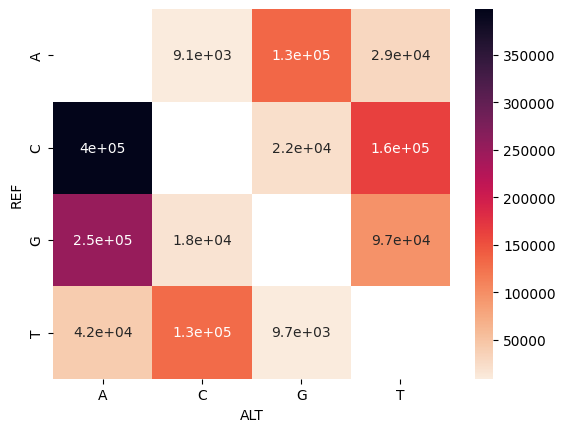

In [26]:
# Get all 12 variations of SNPs and their counts from our artifacts_df
df_pivoted = (
    artifacts_df[["REF", "ALT"]]  
    .value_counts()
    .to_frame()
    .reset_index()
    .pivot("REF", "ALT", 0)
)

# Visualize SNPs in a heatmap
sns.heatmap(
    df_pivoted,
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [27]:
# C>A and G>A base substitutions are the most prevalent, ranging from approximately 150,000 to 250,000 substitutions

In [28]:
df_pivoted

ALT,A,C,G,T
REF,,,,
A,NaN,9080.0,132792.0,29487.0
C,397966.0,NaN,21595.0,162797.0
G,251405.0,18055.0,NaN,96994.0
T,41860.0,129367.0,9700.0,NaN


## SNPs flanking combinations

In [29]:
SNP_variations = artifacts_df[["REF", "ALT"]].value_counts().index.to_list() #.to_frame().sort_values(by=['REF'], ascending=True)
SNP_variations.sort() # looks like: [('A', 'C'),('A', 'G'),('A', 'T'),...]

In [30]:
# orientation bias artifact, arises due to a chemical change in the nucleotide during library prep that results in, for example, G base-paring with A. 
# This kind of artifact has a clear signature (e.g. C to A SNP that occurs predominantly for the middle C in the DNA sequence CCG)

# get all C-A SNPS and see if it is part of CCG
# REF C, ALT A, LSEQ[-1]==C, RSEQ[0]==G ? percentage

nt = ['A', 'T', 'C', 'G']
permutations = [n1+n2 for n1 in nt for n2 in nt] # looks like: ['AA', 'AT', 'AC',..]

def snp_flank_dfs(snp, seq_artifacts_df):
    """ Takes SNP as a tuple (ex: C to A SNP should be ('C', 'A'), where C represents the REF and C represents the ALT). 
        Takes artifacts dataframe as argument. Returns pandas dataframe with counts and percentage of each flanking
        combination or the given SNP.    
    """
    lseq_rseq_df = seq_artifacts_df[['REF', 'ALT', 'LSEQ', 'RSEQ']]
    ref, alt = snp[0], snp[1]
    SNP_df = lseq_rseq_df[(lseq_rseq_df.REF==ref) & (lseq_rseq_df.ALT==alt)]

    # Creates list of dfs for each flanking combination of the given SNP (16 total)
    flank_combo_dfs = []
    for perm in permutations:
        lseq_end = SNP_df.LSEQ.loc[lambda lseq: [(seq[-1]==perm[0]) for seq in lseq]]
        rseq_start = SNP_df.RSEQ.loc[lambda rseq: [(seq[0]==perm[1]) for seq in rseq]]
        l_idx = lseq_end.index.tolist()
        r_idx = rseq_start.index.tolist()
        
        # Use Counter so intersection can be utilized with duplicates. Went from ~2 min per SNP to a few seconds to find shared indexes
        # will provide the lowest count found in either list for each element when you take the intersection.
        shared_idx = list((Counter(r_idx) & Counter(l_idx)).elements()) 
        flank_combo_df = SNP_df.loc[list(set(shared_idx))]
        flank_combo_dfs.append(flank_combo_df)
        
    #return flank_combo_dfs
        
    # Count all the flanking combinations 
    flank_combo_count = {}  # looks like: {'AA': 26500,'AT': 17777,'AC': 17627,...}
    for permutation, flank_combo_df in zip(permutations, flank_combo_dfs):
        flank_combo_count[permutation] = len(flank_combo_df)
        
        
    # Store count and get the percentage for all the flanking combinations in df
    flank_combo_count_df = pd.DataFrame({f'{ref}_to_{alt}_SNP_FLANK':flank_combo_count.keys(),
                                         'COUNT':flank_combo_count.values(),
                                         'PERCENTAGE':[n/sum(flank_combo_count.values())*100 for n in flank_combo_count.values()]})    
    
    return flank_combo_count_df

In [31]:
# list of flank_combo_count_df for each SNP variation (12 total)
flank_combo_count_dfs = []
for snp_var in SNP_variations:
    flank_combo_count_dfs.append(snp_flank_dfs(snp_var, artifacts_df))

In [32]:
flank_combo_count_dfs[0].head()

,A_to_C_SNP_FLANK,COUNT,PERCENTAGE
0,AA,578,6.365639
1,AT,357,3.931718
2,AC,592,6.519824
3,AG,1209,13.314978
4,TA,136,1.497797


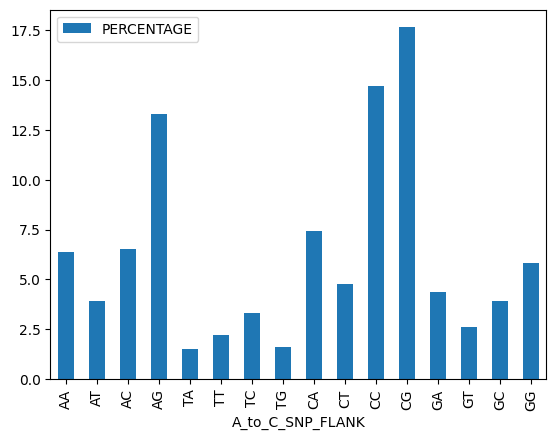

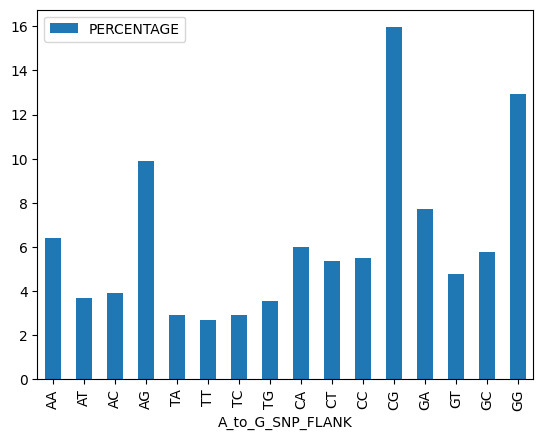

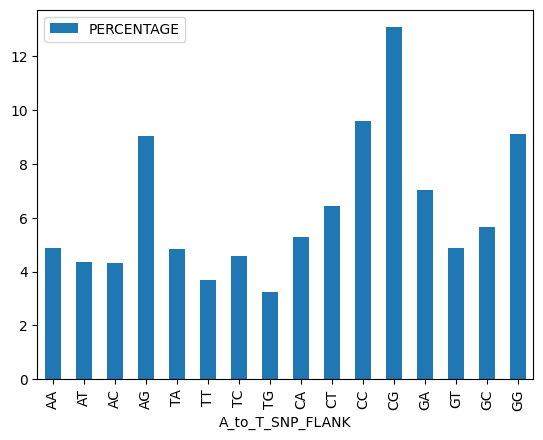

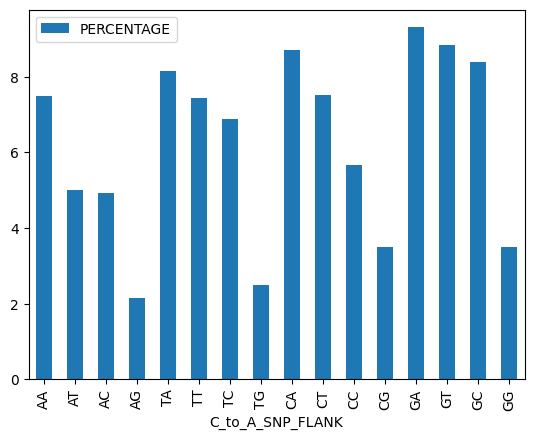

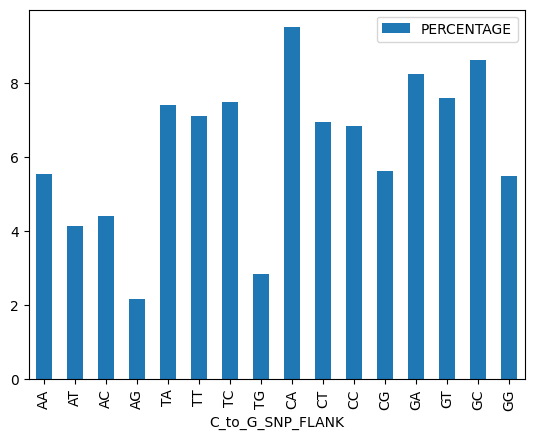

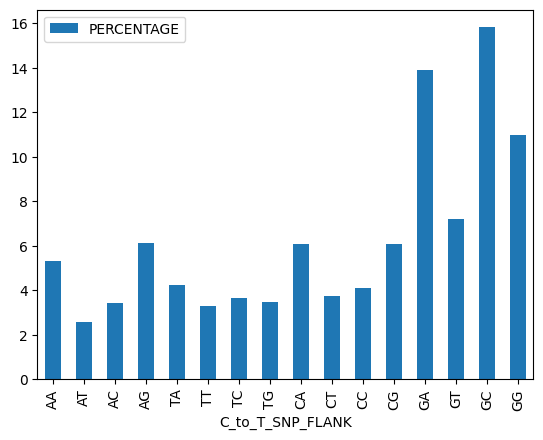

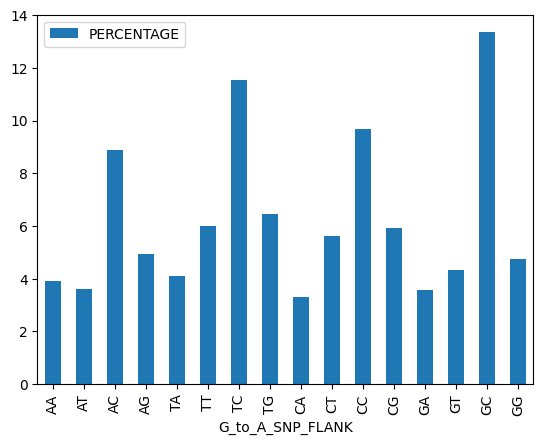

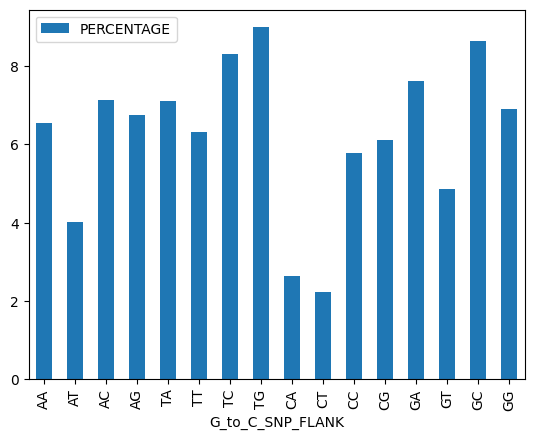

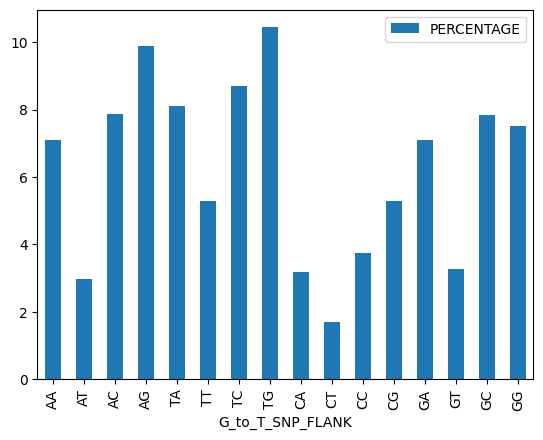

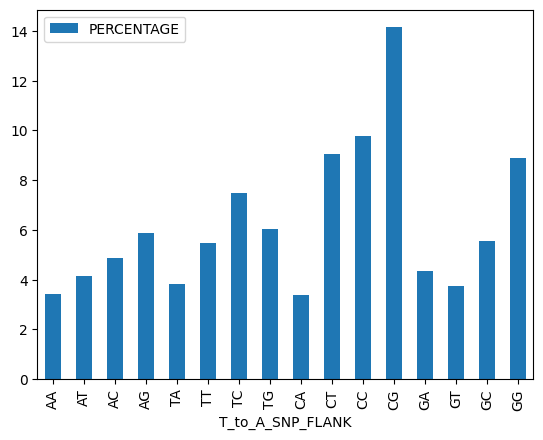

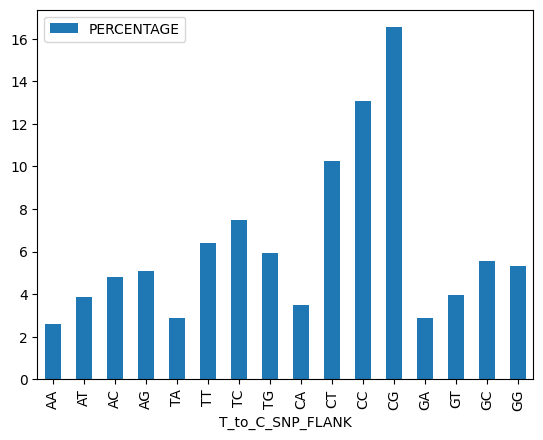

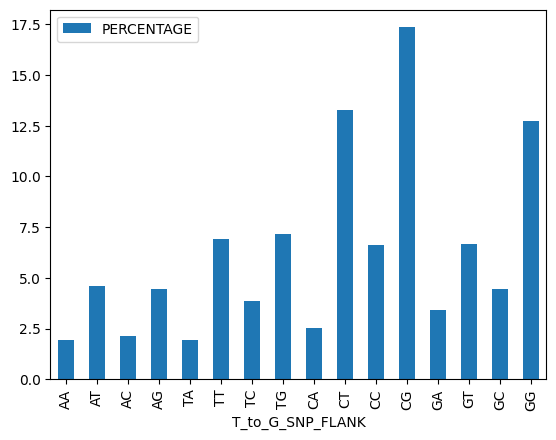

In [33]:
# Visualize each SNP variation's flanking combo distribution
for flank_combo_count_df in flank_combo_count_dfs:
    flank_combo_count_df.plot(x=0, y='PERCENTAGE', kind="bar")
    plt.show()

In [34]:
# Visualize most prominent flanking combo for SNPs in general
# need to add up counts of each flank combo and do heatmap

# Create new df that contains flanks and counts for the first SNP. Update counts downstream
all_SNP_flank_df = flank_combo_count_dfs[0].rename(columns={'A_to_C_SNP_FLANK':'SNP_FLANK'}).drop(columns='PERCENTAGE')
all_SNP_flank_df.head()

,SNP_FLANK,COUNT
0,AA,578
1,AT,357
2,AC,592
3,AG,1209
4,TA,136


In [35]:
# Update counts in all_SNP_flank_df by adding counts for all other SNP flanks
for flank_combo_count_df in flank_combo_count_dfs[1:]:
    all_SNP_flank_df.COUNT += flank_combo_count_df.COUNT

In [36]:
all_SNP_flank_df.head()

,SNP_FLANK,COUNT
0,AA,73122
1,AT,51405
2,AC,72882
3,AG,68583
4,TA,71371


In [37]:
# Add PERCENTAGE column to all_SNP_flank_df
all_SNP_flank_df['PERCENTAGE'] = [n/sum(all_SNP_flank_df.COUNT)*100 for n in all_SNP_flank_df.COUNT]
all_SNP_flank_df.head()

,SNP_FLANK,COUNT,PERCENTAGE
0,AA,73122,5.620022
1,AT,51405,3.950894
2,AC,72882,5.601577
3,AG,68583,5.271163
4,TA,71371,5.485444


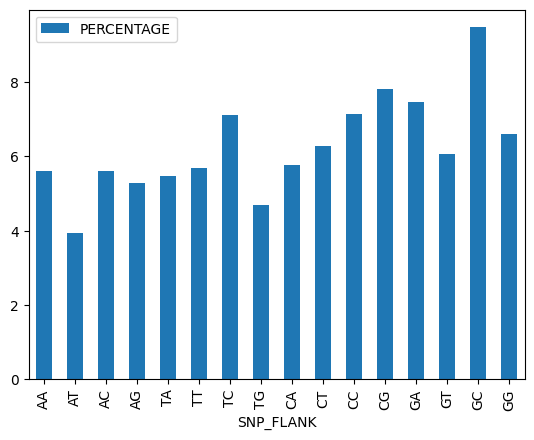

In [38]:
# Visualize percentage of each flank combo
all_SNP_flank_df.plot(x='SNP_FLANK', y='PERCENTAGE', kind="bar")
plt.show()

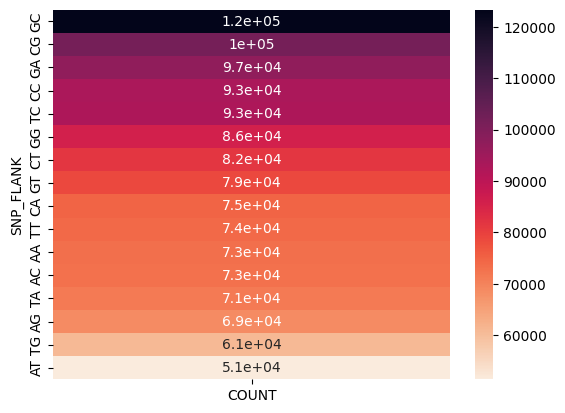

In [39]:
# Visualize count of each flank combo as heatmap
sns.heatmap(
    all_SNP_flank_df.drop(columns='PERCENTAGE')
    .sort_values(by=['COUNT'], ascending=False)
    .set_index(['SNP_FLANK']),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

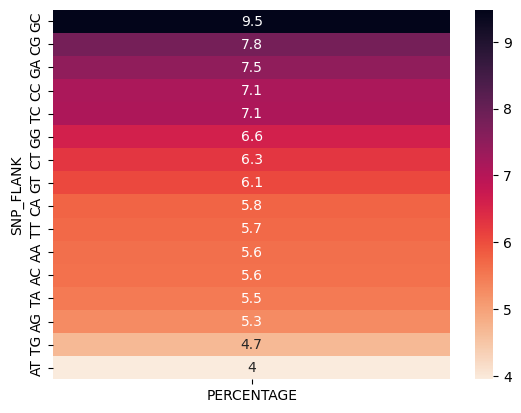

In [40]:
# Visualize count of each flank combo as heatmap
sns.heatmap(
    all_SNP_flank_df.drop(columns='COUNT')
    .sort_values(by=['PERCENTAGE'], ascending=False)
    .set_index(['SNP_FLANK']),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

## Nucleotide Frequencies

In [41]:
# Nucleotide Frequencies
frequency_cols = ['L_A', 'L_T', 'L_G', 'L_C', 
                  'R_A', 'R_T', 'R_G', 'R_C']

artifacts_df[frequency_cols].describe()

,L_A,L_T,L_G,L_C,R_A,R_T,R_G,R_C
count,1.301098e+06,1.301098e+06,1.301098e+06,1.301098e+06,1.301098e+06,1.301098e+06,1.301098e+06,1.301098e+06
mean,2.336902e+01,2.437483e+01,2.599708e+01,2.625908e+01,2.435781e+01,2.347591e+01,2.600666e+01,2.615962e+01
std,1.174077e+01,1.213552e+01,1.213275e+01,1.211007e+01,1.206388e+01,1.173606e+01,1.202776e+01,1.215583e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,1.500000e+01,1.500000e+01,2.000000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.500000e+01
50%,2.000000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.000000e+01,2.500000e+01,2.500000e+01
75%,3.000000e+01,3.000000e+01,3.500000e+01,3.500000e+01,3.000000e+01,3.000000e+01,3.500000e+01,3.500000e+01
max,1.000000e+02,1.000000e+02,8.500000e+01,8.500000e+01,9.500000e+01,9.500000e+01,8.500000e+01,9.000000e+01


In [42]:
# List of pandas series containing value counts for each percentage
frequency_counts = []
for col in frequency_cols:
    frequency_counts.append(artifacts_df[frequency_cols][col].value_counts())

freq_df = pd.concat(frequency_counts, axis=1).fillna(0).reset_index().sort_values(by=['index']).rename(columns={'index':'PERCENTAGE'})
freq_df.head()

,PERCENTAGE,L_A,L_T,L_G,L_C,R_A,R_T,R_G,R_C
10,0.0,20062,17787,13374.0,12072.0,17528.0,19437.0,12340.0,12505.0
7,5.0,70159,63079,48773.0,46003.0,61275.0,69000.0,47789.0,47536.0
4,10.0,141553,128951,106110.0,102260.0,129820.0,140631.0,104701.0,105087.0
2,15.0,203786,190407,166159.0,162698.0,191231.0,201807.0,166035.0,164012.0
0,20.0,225550,218365,204836.0,203878.0,219126.0,224740.0,205567.0,203085.0


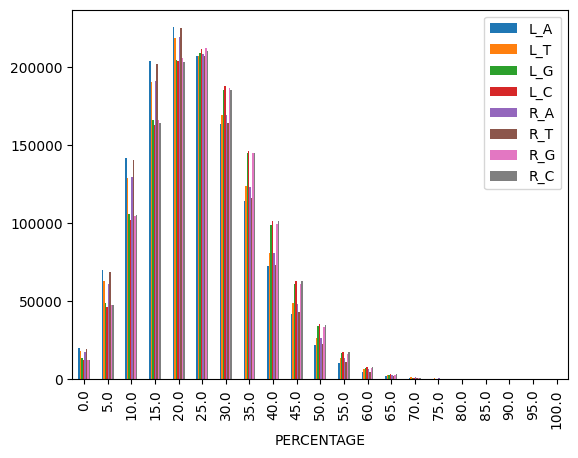

In [43]:
# Visualize all of the frequencies 
freq_df.plot(x="PERCENTAGE", y=frequency_cols, kind="bar")
plt.show()

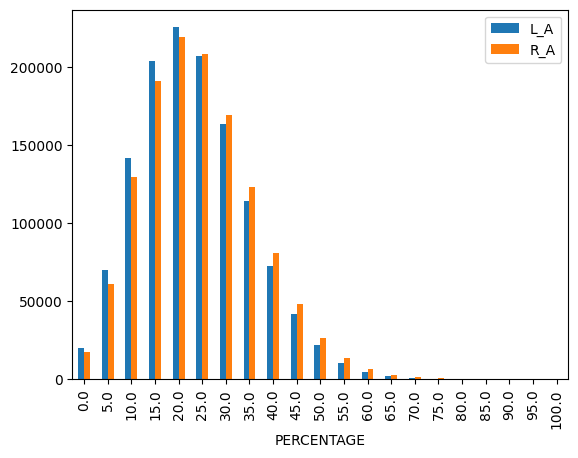

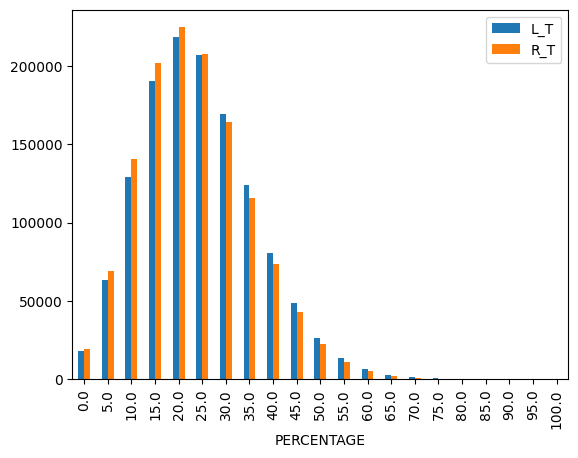

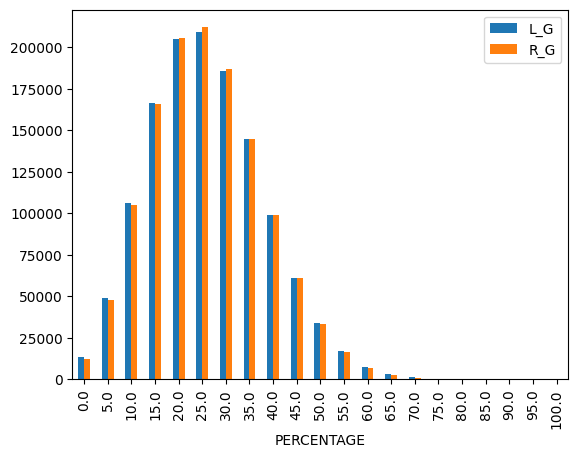

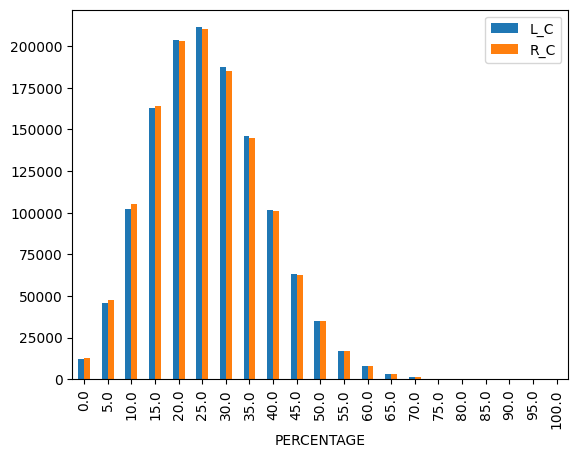

In [44]:
# Visualize each nucleotide frequency of L and R together 
for nt in ('A', 'T', 'G', 'C'):
    freq_df.plot(x='PERCENTAGE', y=['L_'+nt, 'R_'+nt], kind='bar')
    plt.show()

In [45]:
# Visualize AT vs GC content
freq_df['L_AT'] = freq_df['L_A'] + freq_df['L_T']
freq_df['R_AT'] = freq_df['R_A'] + freq_df['R_T']
freq_df['L_GC'] = freq_df['L_G'] + freq_df['L_C']
freq_df['R_GC'] = freq_df['R_G'] + freq_df['R_C']

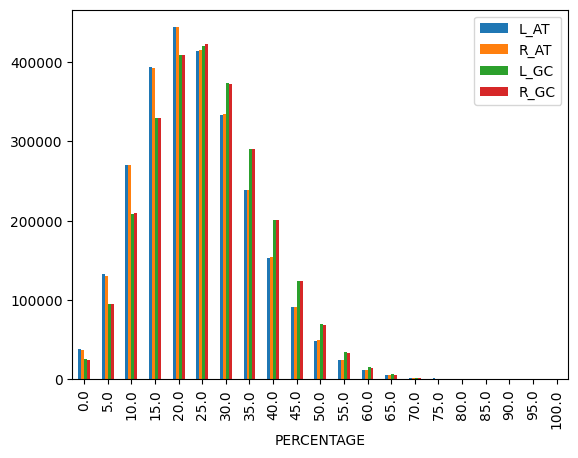

In [46]:
# Visualize AT vs GC content 
freq_df.plot(x="PERCENTAGE", y=['L_AT', 'R_AT', 'L_GC', 'R_GC'], kind="bar")
plt.show()

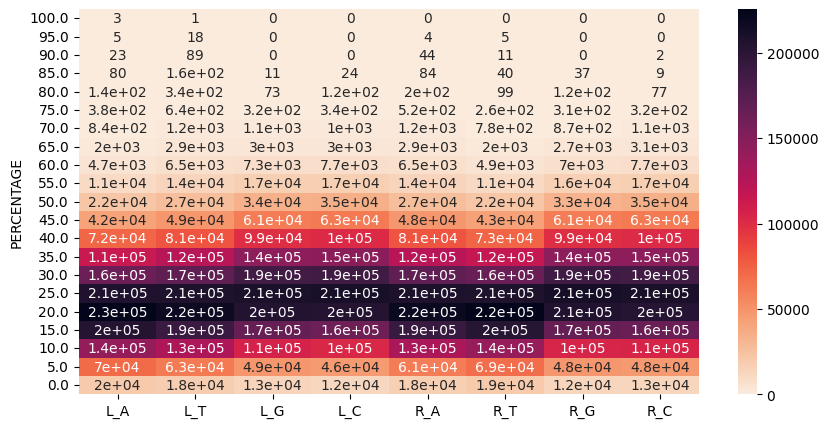

In [48]:
# Visualize count of each nucleotide as heatmap
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(
    freq_df.drop(columns=['L_AT', 'R_AT', 'L_GC', 'R_GC'])
    .sort_values(by=['PERCENTAGE'], ascending=False)
    .set_index(['PERCENTAGE']),    
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [49]:
freq_df.head()

,PERCENTAGE,L_A,L_T,L_G,L_C,R_A,R_T,R_G,R_C,L_AT,R_AT,L_GC,R_GC
10,0.0,20062,17787,13374.0,12072.0,17528.0,19437.0,12340.0,12505.0,37849,36965.0,25446.0,24845.0
7,5.0,70159,63079,48773.0,46003.0,61275.0,69000.0,47789.0,47536.0,133238,130275.0,94776.0,95325.0
4,10.0,141553,128951,106110.0,102260.0,129820.0,140631.0,104701.0,105087.0,270504,270451.0,208370.0,209788.0
2,15.0,203786,190407,166159.0,162698.0,191231.0,201807.0,166035.0,164012.0,394193,393038.0,328857.0,330047.0
0,20.0,225550,218365,204836.0,203878.0,219126.0,224740.0,205567.0,203085.0,443915,443866.0,408714.0,408652.0


## Kmers

In [50]:
# Most prevalent kmers
L_kmer_idx_start = list(artifacts_df.columns).index('L_C') + 1             # Left kmers columns start here
L_kmer_idx_end = list(artifacts_df.columns).index('L_HOMO_POLY_A') - 1     # Left kmers columns end here

R_kmer_idx_start = list(artifacts_df.columns).index('R_C') + 1             # Right kmer columns start here
R_kmer_idx_end = list(artifacts_df.columns).index('R_HOMO_POLY_A') - 1     # Right kmers columns end here

L_kmer_df = artifacts_df.iloc[:, L_kmer_idx_start:L_kmer_idx_end+1]
R_kmer_df = artifacts_df.iloc[:, R_kmer_idx_start:R_kmer_idx_end+1]

# dictionary for each kmer and total count
L_kmer_counts = {}
for col in L_kmer_df.columns:
    L_kmer_counts[col.lstrip('L_')] = L_kmer_df[col].sum()

R_kmer_counts = {}
for col in R_kmer_df.columns:
    R_kmer_counts[col.lstrip('R_')] = R_kmer_df[col].sum()


kmer_df = pd.DataFrame({'L_KMER':L_kmer_counts.keys(),
                       'L_COUNT':L_kmer_counts.values(),
                       'R_KMER':R_kmer_counts.keys(),
                       'R_COUNT':R_kmer_counts.values()})

In [51]:
"""
frequency_counts = []
for col in frequency_cols:
    frequency_counts.append(artifacts_df[frequency_cols][col].value_counts())

freq_df = pd.concat(frequency_counts, axis=1).fillna(0).reset_index().sort_values(by=['index']).rename(columns={'index':'PERCENTAGE'})
freq_df.head()
"""


L_kmer_counts = []
for col in L_kmer_df.columns:
    L_kmer_counts.append(L_kmer_df[col].value_counts())


    
L_kmer_counts[0]

0    1165341
1     125354
2       9691
3        658
4         43
5          8
6          3
Name: L_GAAG, dtype: int64

In [52]:
t_df = pd.concat(L_kmer_counts, axis=1).fillna(0)
t_df

,L_GAAG,L_AAGA,L_AGAA,L_AAGC,L_AGCC,L_GCCC,L_CCCC,L_CCCT,L_CCTG,L_CTGC,...,L_GTAT,L_TTAG,L_TATG,L_TAAA,L_TTCG,L_ATAT,L_AATT,L_ATTA,L_AATA,L_TATA
0,1165341.0,1187353.0,1174566.0,1214752.0,1181976.0,1175872.0,1205712.0,1186256.0,1123781.0,1140561.0,...,1260923.0,1262021.0,1249241.0,1239787.0,1272666.0,1251777.0,1233100.0,1256837.0,1245814.0,1266394.0
1,125354.0,104184.0,116250.0,84178.0,114019.0,117242.0,68355.0,108980.0,167124.0,145779.0,...,39514.0,38598.0,50860.0,58933.0,28165.0,45742.0,65827.0,42420.0,52661.0,32220.0
2,9691.0,8777.0,9516.0,2145.0,4951.0,7698.0,20346.0,5652.0,9939.0,13450.0,...,654.0,479.0,981.0,2309.0,266.0,3238.0,2143.0,1760.0,2491.0,2245.0
3,658.0,703.0,689.0,23.0,152.0,283.0,5033.0,207.0,251.0,1067.0,...,7.0,0.0,16.0,67.0,1.0,275.0,27.0,72.0,122.0,179.0
4,43.0,68.0,70.0,0.0,0.0,3.0,1171.0,3.0,3.0,159.0,...,0.0,0.0,0.0,0.0,0.0,35.0,0.0,8.0,8.0,38.0
5,8.0,9.0,6.0,0.0,0.0,0.0,298.0,0.0,0.0,64.0,...,0.0,0.0,0.0,2.0,0.0,16.0,1.0,1.0,2.0,8.0
6,3.0,4.0,1.0,0.0,0.0,0.0,120.0,0.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,9.0
7,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
8,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
t_df.drop(labels=0, axis=0, inplace=True)

In [54]:
t_df

,L_GAAG,L_AAGA,L_AGAA,L_AAGC,L_AGCC,L_GCCC,L_CCCC,L_CCCT,L_CCTG,L_CTGC,...,L_GTAT,L_TTAG,L_TATG,L_TAAA,L_TTCG,L_ATAT,L_AATT,L_ATTA,L_AATA,L_TATA
1,125354.0,104184.0,116250.0,84178.0,114019.0,117242.0,68355.0,108980.0,167124.0,145779.0,...,39514.0,38598.0,50860.0,58933.0,28165.0,45742.0,65827.0,42420.0,52661.0,32220.0
2,9691.0,8777.0,9516.0,2145.0,4951.0,7698.0,20346.0,5652.0,9939.0,13450.0,...,654.0,479.0,981.0,2309.0,266.0,3238.0,2143.0,1760.0,2491.0,2245.0
3,658.0,703.0,689.0,23.0,152.0,283.0,5033.0,207.0,251.0,1067.0,...,7.0,0.0,16.0,67.0,1.0,275.0,27.0,72.0,122.0,179.0
4,43.0,68.0,70.0,0.0,0.0,3.0,1171.0,3.0,3.0,159.0,...,0.0,0.0,0.0,0.0,0.0,35.0,0.0,8.0,8.0,38.0
5,8.0,9.0,6.0,0.0,0.0,0.0,298.0,0.0,0.0,64.0,...,0.0,0.0,0.0,2.0,0.0,16.0,1.0,1.0,2.0,8.0
6,3.0,4.0,1.0,0.0,0.0,0.0,120.0,0.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,9.0
7,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
8,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
l_kmer = kmer_df[['L_KMER', 'L_COUNT']].set_index('L_KMER')
l_kmer.sort_values(by=['L_COUNT'], inplace=True, ascending=False)
l_kmer.head()

,L_COUNT
L_KMER,
CCAG,196447
CTGG,195384
GCTG,189905
CAGC,188455
CCTG,187767


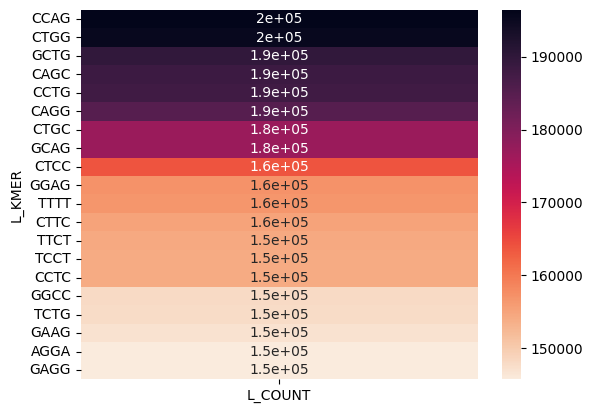

In [56]:
# Separate heatmap for L and R kmers
sns.heatmap(
    l_kmer.head(20),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [57]:
r_kmer = kmer_df[['R_KMER', 'R_COUNT']].set_index('R_KMER')
r_kmer.sort_values(by=['R_COUNT'], inplace=True, ascending=False)
r_kmer.head()

,R_COUNT
R_KMER,
CCAG,196930
CTGG,194441
CAGC,194313
CAGG,188661
CCTG,186467


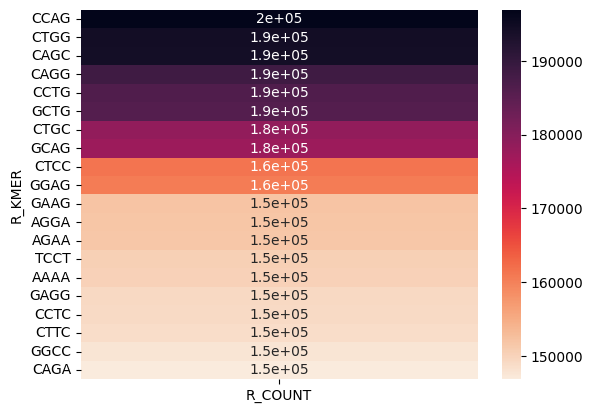

In [58]:
# Separate heatmap for L and R kmers
sns.heatmap(
    r_kmer.head(20),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [59]:
l = l_kmer.head(20).index.tolist()
r = r_kmer.head(20).index.tolist()
both = [kmer for kmer in l if kmer in r]
print(both), len(both)   

['CCAG', 'CTGG', 'GCTG', 'CAGC', 'CCTG', 'CAGG', 'CTGC', 'GCAG', 'CTCC', 'GGAG', 'CTTC', 'TCCT', 'CCTC', 'GGCC', 'GAAG', 'AGGA', 'GAGG']


(None, 17)

## Homopolymers

In [60]:
# Most homopolymers
homopolymer_cols = ['L_HOMO_POLY_A', 'L_HOMO_POLY_T', 'L_HOMO_POLY_G', 'L_HOMO_POLY_C',
                    'R_HOMO_POLY_A', 'R_HOMO_POLY_T', 'R_HOMO_POLY_G', 'R_HOMO_POLY_C']

artifacts_df[homopolymer_cols]

L_HOMO_POLY_A  L_HOMO_POLY_T  L_HOMO_POLY_G  L_HOMO_POLY_C  \
CHROM POS                                                                     
chr1  944168                 0              0              5              0   
      961530                 0              0              0              3   
      963159                 0              0              0              0   
      963397                 0              0              0              4   
      1022252                0              0              3              3   
...                        ...            ...            ...            ...   
chrX  143629528              0              0              3              3   
      143629683              0              3              0              0   
      143629724              0              3              0              0   
      143630393              0              3              3              0   
      143631074              3              3              0              0   

                 R_HOMO_POLY_A  R_HOMO_POLY_T  R_HOMO_POLY_G  R_HOMO_POLY_C  
CHROM POS                                                                    
chr1  944168                 3              0              4              0  
      961530                 0              0              0              0  
      963159                 0              0              0              0  
      963397                 0              0              3              0  
      1022252                0              0              0              0  
...                        ...            ...            ...            ...  
chrX  143629528              0              0              0              0  
      143629683              3              3              0              0  
      143629724              3              0              0              0  
      143630393              3              0              0              0  
      143631074              4              0              3              0  

[1301098 rows x 8 columns]

In [61]:
# List of pandas series containing value counts for each homopolymer
homopoly_counts = []
for col in homopolymer_cols:
    homopoly_counts.append(artifacts_df[homopolymer_cols][col].value_counts())

homopoly_counts
homopoly_df = pd.concat(homopoly_counts, axis=1).fillna(0).reset_index().sort_values(by=['index']).rename(columns={'index':'HOMOPOLYMER SIZE'}).drop(labels=0, axis=0)
homopoly_df.head()

,HOMOPOLYMER SIZE,L_HOMO_POLY_A,L_HOMO_POLY_T,L_HOMO_POLY_G,L_HOMO_POLY_C,R_HOMO_POLY_A,R_HOMO_POLY_T,R_HOMO_POLY_G,R_HOMO_POLY_C
1,3,175972,189513,214050.0,215610.0,188579.0,178082.0,214444.0,214214.0
2,4,58405,65299,69200.0,71165.0,64435.0,59104.0,69048.0,70499.0
3,5,17763,21151,20441.0,19646.0,20873.0,18080.0,18957.0,21283.0
4,6,4585,5945,3963.0,3894.0,5872.0,4577.0,3627.0,4155.0
5,7,1424,2091,537.0,541.0,2110.0,1483.0,511.0,570.0


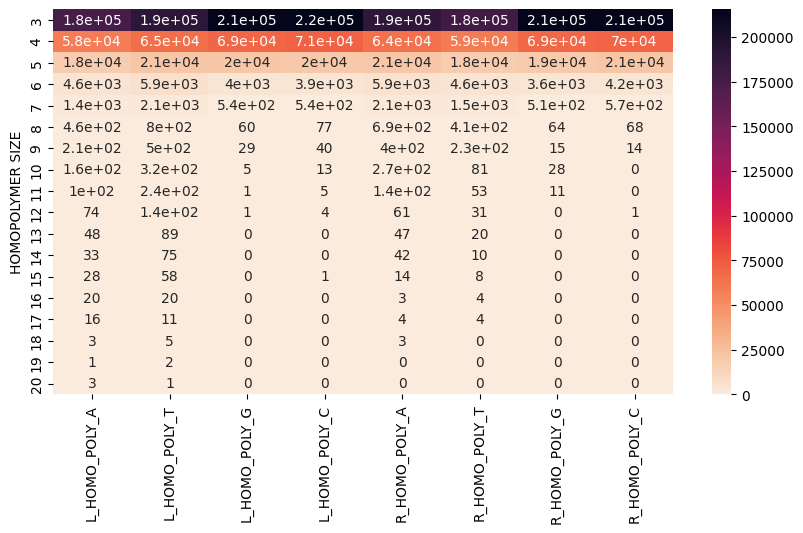

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(
    homopoly_df.set_index(['HOMOPOLYMER SIZE']),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

## Palindromes

In [63]:
# Most prevalent palindrome size
palindrome_cols = ['L_PALINDROME', 'R_PALINDROME']

artifacts_df[palindrome_cols]

L_PALINDROME  R_PALINDROME
CHROM POS                                  
chr1  944168                4             4
      961530                6             4
      963159                6             6
      963397                6             6
      1022252               6             0
...                       ...           ...
chrX  143629528             8             0
      143629683             4             8
      143629724             0             4
      143630393             4             4
      143631074             4             0

[1301098 rows x 2 columns]

In [64]:
# List of pandas series containing value counts for each palindrome
palindrome_counts = []
for col in palindrome_cols:
    palindrome_counts.append(artifacts_df[palindrome_cols][col].value_counts())

palindrome_counts
palindrome_df = pd.concat(palindrome_counts, axis=1).reset_index().rename(columns={'index':'PALINDROME SIZE'}).drop(labels=0, axis=0)
palindrome_df.head()

,PALINDROME SIZE,L_PALINDROME,R_PALINDROME
1,4,497407,497398
2,6,174893,176057
3,8,46881,46767
4,10,11301,11630
5,12,2599,2621


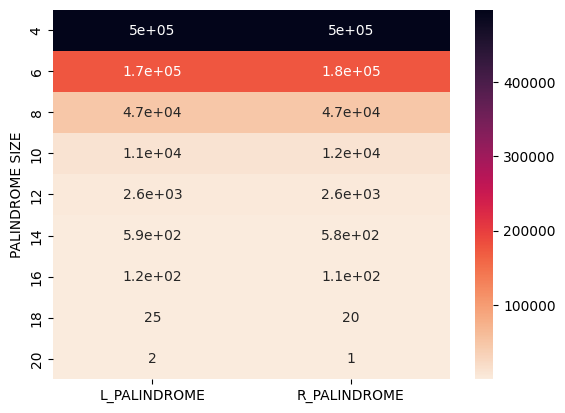

In [65]:
# Visualize all of the palindrome sizes 
sns.heatmap(
    palindrome_df.set_index(['PALINDROME SIZE']),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

## Hairpin loops

In [66]:
# Most prevalent hairpin size
hairpin_cols = ['L_HAIRPIN', 'R_HAIRPIN']

artifacts_df[hairpin_cols]

L_HAIRPIN  R_HAIRPIN
CHROM POS                            
chr1  944168             0          0
      961530             8          0
      963159             0          0
      963397             5          0
      1022252            0          0
...                    ...        ...
chrX  143629528          0          7
      143629683          0          0
      143629724          0          0
      143630393          0          0
      143631074          7          5

[1301098 rows x 2 columns]

In [67]:
# List of pandas series containing value counts for each hairpin
hairpin_counts = []
for col in hairpin_cols:
    hairpin_counts.append(artifacts_df[hairpin_cols][col].value_counts())

hairpin_counts
hairpin_df = pd.concat(hairpin_counts, axis=1).reset_index().sort_values(by=['index']).rename(columns={'index':'HAIRPIN-LOOP SIZE'}).drop(labels=0, axis=0)
hairpin_df.head()

,HAIRPIN-LOOP SIZE,L_HAIRPIN,R_HAIRPIN
1,4,39579,40103
2,5,38060,37967
4,6,33890,33884
3,7,37009,36990
5,8,33818,33359


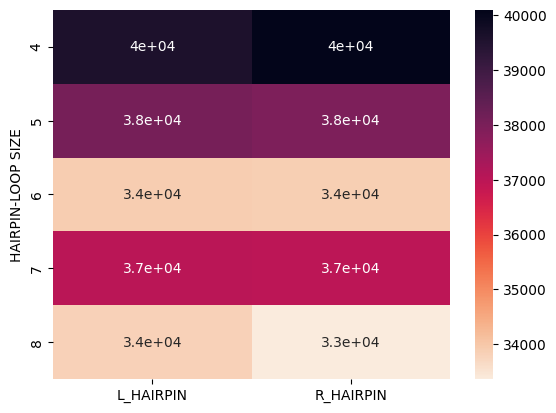

In [68]:
sns.heatmap(
    hairpin_df.set_index(['HAIRPIN-LOOP SIZE']),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

# Find relative abundance of content, kmer, homopolymer, palindrome, hairpin in exome region

In [2]:
# read in agilentSureSelectv5_seqs.fa -- these are nucleotide sequences for this exome region

file = 'agilentSureSelectv5_seqs.fa'

seq_list = []

with open(file, 'r') as f:
    for line in f:
        if not line.startswith('>'):
            seq_list.append(line.strip('\n'))
            
exome_seq = ''.join(seq_list)

### Nucleotide Content

In [24]:
nt_d = get_metrics.content([exome_seq], '')

# perfect of flanking region nucleotides shows higher G and C content 
# but entire exome shows even amount / lower amount

In [25]:
new_content_d = {}
for key in nt_d[0]:
    new_content_d[key.lstrip('_')] = nt_d[0][key]

In [29]:
exome_content = pd.DataFrame({'NUCLEOTIDE':new_content_d.keys(),
                              'PERCENTAGE':new_content_d.values()})

#exome_content.set_index('NUCLEOTIDE', inplace=True)
exome_content

,NUCLEOTIDE,PERCENTAGE
0,A,25.08
1,T,25.08
2,G,24.92
3,C,24.93


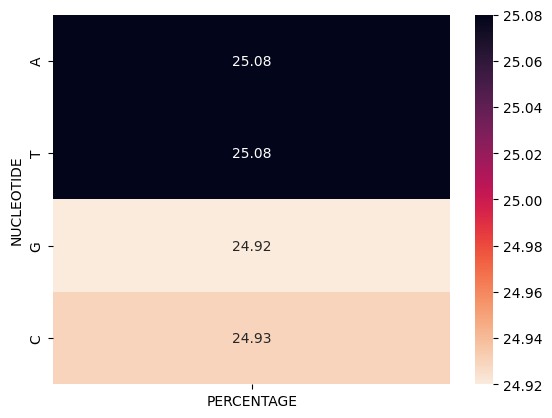

In [40]:
sns.heatmap(
    exome_content.set_index('NUCLEOTIDE'),
    annot=True,
    fmt=".2f",
    cmap="rocket_r"
)
plt.show()

### Kmer

In [72]:
kmer_d = get_metrics.find_kmer([exome_seq.upper()], '')

In [73]:
new_kmer_d = {}
for key in kmer_d[0]:
    new_kmer_d[key.lstrip('_')] = kmer_d[0][key]

In [74]:
exome_kmer = pd.DataFrame({'KMER':new_kmer_d.keys(),
                           'COUNT':new_kmer_d.values()})

exome_kmer.head()

,KMER,COUNT
0,TTGG,220985
1,TGGC,268761
2,GGCG,125516
3,GCGC,104766
4,CGCC,125202


In [75]:
exome_kmer.sort_values(by=['COUNT'], inplace=True, ascending=False)
exome_kmer.set_index('KMER', inplace=True)
exome_kmer.head()

,COUNT
KMER,
AAAA,400556
CTGG,399748
CCAG,398075
CCTG,394378
TTTT,393428


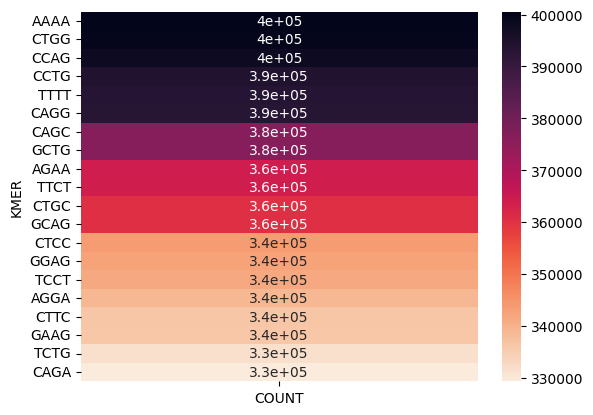

In [76]:
sns.heatmap(
    exome_kmer.head(20),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [77]:
#l = l_kmer.head(20).index.tolist()
#r = r_kmer.head(20).index.tolist()
#both = [kmer for kmer in l if kmer in r]
#print(both), len(both)   

In [78]:
all_kmer = exome_kmer.head(20).index.tolist()

In [79]:
shared_kmers = [kmer for kmer in all_kmer if kmer in l and kmer in r]
print(shared_kmers)
len(shared_kmers)

#left and right kmers shared 17, all share 14

['CTGG', 'CCAG', 'CCTG', 'CAGG', 'CAGC', 'GCTG', 'CTGC', 'GCAG', 'CTCC', 'GGAG', 'TCCT', 'AGGA', 'CTTC', 'GAAG']


14

### Homopolymer

In [80]:
def find_kmer(dna_list, flank, kmer_size=4):
    """Takes a list of DNA sequences and an integer for kmer_size. 
        Finds all kmers and their counts.  Returns a list of dictionaries
        Each dict contains all kmers and their counts for each seq
    """ 
    # kmer_dict_list holds a dict for each lseq/rseq
    # kmer_dict_list is -- [{seq1_4mer},{seq2_4mer},{seq3_4mer}...etc]
   
    kmer_dict_list = [] 
    for seq in dna_list: #dna_list=['GGGGGTGGTGG']
        kmer_list = []
        # kmer lists for each seq
        # Any sequence of length L will contain (L - k + 1) total k-mers
        for i in range(len(seq)-kmer_size+1):
            kmer = seq[i:i+kmer_size]
            kmer_list.append(kmer)
        # kmer_count() returns a dictionary
        kmer_dict = kmer_count(kmer_list, flank)
        kmer_dict_list.append(kmer_dict)            
    
    return kmer_dict_list

# helper function for find_kmer()
def kmer_count(kmer_list, flank):
    """Given a list of kmers, find the count of each unique one. Return dictionary where
        kmer is key and count is value.
    """
    kmer_dict = {}
    for kmer in kmer_list:   #kmer_list ['GGGG', 'GGGG', 'GGGT', 'GGTG', 'GTGG', 'TGGT', 'GGTG', 'GTGG']
        kmer = flank+'_'+kmer
        if kmer not in kmer_dict:
            kmer_dict[kmer] = 1    
        else:
            kmer_dict[kmer] += 1           
    return kmer_dict

# homopolymer 3 or more of a base (yes/no) -- do for each base
def homopolymer(dna_list, flank, min_polymer_size=3):
    """Takes a list of DNA sequences and an integer for minimum polymer size. Calls find_kmer
       function and determines if kmers are homopolymers. Does this for all kmer sizes from min_polymer_size
       to length of the sequence.  Returns list of dictionaries showing largest homopolymer size for each base"""
    
    # call find_kmer function which was previously defined to find kmer of size min_polymer_size and their counts (counts irrelevant here)
    kmer_dict_list = find_kmer(dna_list, flank, min_polymer_size)
    # returns something like [{'R_GGG': 4, 'R_GGT': 2, 'R_GTG': 2, 'R_TGG': 1}, ...]
    
    #count_d = {'count_3':{'HOMOPOLY_A':0, 'HOMOPOLY_T:5'}}
    
    count_d = {}
    
    for i in range(3,21):
        count_d[f'count_{i}'] = {}
    
    
    homopoly_list = []
    for d in kmer_dict_list:
        homo_poly_d = {}
        # if kmer contains all the same bases then it is a homopolymer of size k
        if flank+'_'+('A'*min_polymer_size) in d.keys():
            homo_poly_d[flank+'_HOMO_POLY_A'] = min_polymer_size
            count_d['count_3']['HOMO_POLY_A'] = d[flank+'_'+('A'*min_polymer_size)]
        else:
            homo_poly_d[flank+'_HOMO_POLY_A'] = 0
            count_d['count_3']['HOMO_POLY_A'] = 0
        if flank+'_'+('T'*min_polymer_size) in d.keys():
            homo_poly_d[flank+'_HOMO_POLY_T'] = min_polymer_size
            count_d['count_3']['HOMO_POLY_T'] = d[flank+'_'+('T'*min_polymer_size)]
        else:
            homo_poly_d[flank+'_HOMO_POLY_T'] = 0
            count_d['count_3']['HOMO_POLY_T'] = 0
        if flank+'_'+('G'*min_polymer_size) in d.keys():
            homo_poly_d[flank+'_HOMO_POLY_G'] = min_polymer_size
            count_d['count_3']['HOMO_POLY_G'] = d[flank+'_'+('G'*min_polymer_size)]
        else:
            homo_poly_d[flank+'_HOMO_POLY_G'] = 0
            count_d['count_3']['HOMO_POLY_G'] = 0
        if flank+'_'+('C'*min_polymer_size) in d.keys():
            homo_poly_d[flank+'_HOMO_POLY_C'] = min_polymer_size
            count_d['count_3']['HOMO_POLY_C'] = d[flank+'_'+('C'*min_polymer_size)]
        else:
            homo_poly_d[flank+'_HOMO_POLY_C'] = 0
            count_d['count_3']['HOMO_POLY_C'] = 0
        homopoly_list.append(homo_poly_d)

    # test for homopolymers of up to the length of the LSEQ/RSEQ 
    for polymer_size in range(min_polymer_size + 1, 21):  # 4, 21 (len(dna_list[0]))
        kmer_dict_list = find_kmer(dna_list, flank, polymer_size)
        #print(kmer_dict_list)
        
        # j is used to index homopolymer_list so each dictionary in that list can be modified 
        j = 0

        for d in kmer_dict_list:

            homo_poly_d2 = {}
            
            if flank+'_'+('A'*polymer_size) in d.keys():
                homo_poly_d2[flank+'_HOMO_POLY_A'] = polymer_size
                count_d[f'count_{polymer_size}']['HOMO_POLY_A'] = d[flank+'_'+('A'*polymer_size)]
            # no larger homopolymer found, then keep the previous value that is already stored in the initial dictionary
            else:
                homo_poly_d2[flank+'_HOMO_POLY_A'] = homopoly_list[j][flank+'_HOMO_POLY_A']
                count_d[f'count_{polymer_size}']['HOMO_POLY_A'] = 0
            if flank+'_'+('T'*polymer_size) in d.keys():
                homo_poly_d2[flank+'_HOMO_POLY_T'] = polymer_size
                count_d[f'count_{polymer_size}']['HOMO_POLY_T'] = d[flank+'_'+('T'*polymer_size)]
            else:
                homo_poly_d2[flank+'_HOMO_POLY_T'] = homopoly_list[j][flank+'_HOMO_POLY_T']
                count_d[f'count_{polymer_size}']['HOMO_POLY_T'] = 0
            if flank+'_'+('G'*polymer_size) in d.keys():
                homo_poly_d2[flank+'_HOMO_POLY_G'] = polymer_size
                count_d[f'count_{polymer_size}']['HOMO_POLY_G'] = d[flank+'_'+('G'*polymer_size)]
            else:
                homo_poly_d2[flank+'_HOMO_POLY_G'] = homopoly_list[j][flank+'_HOMO_POLY_G']
                count_d[f'count_{polymer_size}']['HOMO_POLY_G'] = 0
            if flank+'_'+('C'*polymer_size) in d.keys():
                homo_poly_d2[flank+'_HOMO_POLY_C'] = polymer_size
                count_d[f'count_{polymer_size}']['HOMO_POLY_C'] = d[flank+'_'+('C'*polymer_size)]
            else:
                homo_poly_d2[flank+'_HOMO_POLY_C'] = homopoly_list[j][flank+'_HOMO_POLY_C']
                count_d[f'count_{polymer_size}']['HOMO_POLY_C'] = 0
            
            # homo_poly_d2 contains updated data for each polymer size -- update the previous dictionary with new dictionary
            homopoly_list[j].update(homo_poly_d2)
            
            # increment j to access next dictionary in homo_poly_list
            j += 1
            
    return homopoly_list, count_d   

In [117]:
start=time.time()

#homopoly_d = get_metrics.homopolymer([exome_seq.upper()], '')
#took too long to do sliding window up to length of seq length
#len(exome_seq) 50446305

homopoly_d, count_d = homopolymer([exome_seq.upper()], '')

end=time.time()
print(f'Run Time: {(end-start)/60} min')

Run Time: 9.129106140136718 min


In [118]:
homopoly_d

[{'_HOMO_POLY_A': 20,
  '_HOMO_POLY_T': 20,
  '_HOMO_POLY_G': 18,
  '_HOMO_POLY_C': 18}]

In [119]:
count_d

{'count_3': {'HOMO_POLY_A': 1177047,
  'HOMO_POLY_T': 1169854,
  'HOMO_POLY_G': 985036,
  'HOMO_POLY_C': 985130},
 'count_4': {'HOMO_POLY_A': 400556,
  'HOMO_POLY_T': 393428,
  'HOMO_POLY_G': 276434,
  'HOMO_POLY_C': 277028},
 'count_5': {'HOMO_POLY_A': 139879,
  'HOMO_POLY_T': 134099,
  'HOMO_POLY_G': 66225,
  'HOMO_POLY_C': 66554},
 'count_6': {'HOMO_POLY_A': 54768,
  'HOMO_POLY_T': 50322,
  'HOMO_POLY_G': 12232,
  'HOMO_POLY_C': 12516},
 'count_7': {'HOMO_POLY_A': 27505,
  'HOMO_POLY_T': 23816,
  'HOMO_POLY_G': 2039,
  'HOMO_POLY_C': 2114},
 'count_8': {'HOMO_POLY_A': 16252,
  'HOMO_POLY_T': 13190,
  'HOMO_POLY_G': 503,
  'HOMO_POLY_C': 532},
 'count_9': {'HOMO_POLY_A': 10943,
  'HOMO_POLY_T': 8436,
  'HOMO_POLY_G': 224,
  'HOMO_POLY_C': 229},
 'count_10': {'HOMO_POLY_A': 7729,
  'HOMO_POLY_T': 5651,
  'HOMO_POLY_G': 127,
  'HOMO_POLY_C': 129},
 'count_11': {'HOMO_POLY_A': 5559,
  'HOMO_POLY_T': 3882,
  'HOMO_POLY_G': 73,
  'HOMO_POLY_C': 74},
 'count_12': {'HOMO_POLY_A': 4052,
  'H

In [120]:
new_homopoly_d = {}
for key in homopoly_d[0]:
    new_homopoly_d[key.lstrip('_')] = homopoly_d[0][key]

In [121]:
exome_homopoly = pd.DataFrame({'KEY':new_homopoly_d.keys(),
                           'LARGEST_SIZE':new_homopoly_d.values()})

exome_homopoly.head()

,KEY,LARGEST_SIZE
0,HOMO_POLY_A,20
1,HOMO_POLY_T,20
2,HOMO_POLY_G,18
3,HOMO_POLY_C,18


In [135]:
# find counts of each homopoly size that appears instead of just largest present
exome_homopoly_df = pd.DataFrame({'HOMOPOLYMER_SIZE':range(3,21),
                                 'HOMOPOLY_A':[count_d[f'count_{i}']['HOMO_POLY_A'] for i in range(3,21)], 
                                  'HOMOPOLY_T':[count_d[f'count_{i}']['HOMO_POLY_T'] for i in range(3,21)], 
                                  'HOMOPOLY_G':[count_d[f'count_{i}']['HOMO_POLY_G'] for i in range(3,21)], 
                                  'HOMOPOLY_C':[count_d[f'count_{i}']['HOMO_POLY_C'] for i in range(3,21)]})

exome_homopoly_df.tail()

,HOMOPOLYMER_SIZE,HOMOPOLY_A,HOMOPOLY_T,HOMOPOLY_G,HOMOPOLY_C
13,16,957,546,5,5
14,17,619,351,2,3
15,18,395,215,1,1
16,19,242,128,0,0
17,20,144,75,0,0


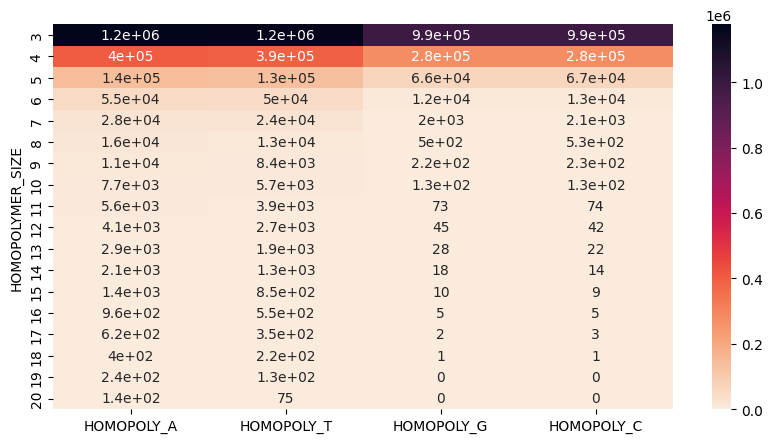

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(
    exome_homopoly_df.set_index(['HOMOPOLYMER_SIZE']),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [136]:
# There is a HUGE abundance of long homopolymer A's and T's in the exome

### Palindrome

In [49]:
def palindrome(dna_list, flank):
    """Takes a list of DNA sequences and flank. Calls find_kmer function and determines if kmers are palindromes. 
       Does this for all kmer sizes from 3 to length of the sequence. Find the reverse complement of each 
       kmer sequence by calling complement() function. If reverse complement is identical to original 
       kmer sequence, it is a palindrome. Returns list containing largest palindrome size for each seq.     
    """
    # ordered array filled with 0's representing palindrome size for each seq -- if palindrome exists, update 0 value with largest palindrome size
    palindrome_list = [0] * len(dna_list)
    
    #count_d = {'count_4':100, 'count_6':50}

    count_d = {}

    for i in range(4,21,2):
        count_d[f'count_{i}'] = 0


    # test for palindromes of size 4 up to the length of the LSEQ/RSEQ 
    for kmer_size in range(4, 21, 2):  # 4, 21 (len(dna_list[0]))
        kmer_dict_list = find_kmer(dna_list, flank, kmer_size)
        # returns something like [{'R_GAGA': 4, 'R_GGTA': 2, 'R_GTGA': 2, 'R_TGGA': 1}, ...]
        
        # j used to index palindrome_list
        j = 0
        
        for d in kmer_dict_list:
            # paldrome_d has kmer seq as key and size
            #palindrome_d = {}
            # if kmer is a palindrome then the sequence has palindrome of size kmer_size
            for kmer in d:
                kmer = kmer.lstrip(flank+'_') # gives kmer without the L_ and R_ tags
                comp = complement(kmer)
                rev_complement = comp[::-1]
                
                if rev_complement == kmer:
                    #print(kmer_size, kmer, d[flank+'_'+kmer])
                    count_d[f'count_{kmer_size}'] += d[flank+'_'+kmer]
                
                if rev_complement == kmer and palindrome_list[j] < kmer_size:
                    # update size of palindrome for that seq based on index
                    palindrome_list[j] = kmer_size
                   
                
            # update j so we can move on to next seq
            j += 1
        
    return palindrome_list, count_d


# helper function for palindrome()
def complement(seq):
    """Takes a DNA sequence. Returns the complement of the sequence"""
    complement = seq.replace('A','t').replace('T','a').replace('G','c').replace('C','g').upper()
    return(complement)

In [105]:
start=time.time()

#homopoly_d = get_metrics.homopolymer([exome_seq.upper()], '')
#took too long to do sliding window up to length of seq length
#len(exome_seq) 50446305

#homopoly_d, count_d = homopolymer([exome_seq.upper()], '')
palindrome_d, count_d = palindrome([exome_seq.upper()], '')

end=time.time()
print(f'Run Time: {(end-start)/60} min')

Run Time: 8.764905405044555 min


In [106]:
palindrome_d #15min len to 20, largest is 20

[20]

In [107]:
count_d

{'count_4': 2416913,
 'count_6': 673776,
 'count_8': 190008,
 'count_10': 53842,
 'count_12': 15034,
 'count_14': 4246,
 'count_16': 1196,
 'count_18': 361,
 'count_20': 142}

In [109]:
exome_palindrome = pd.DataFrame({'PALINDROME_SIZE':[key.lstrip('count_') for key in count_d],
                                 'COUNT':count_d.values()})

exome_palindrome.head()

,PALINDROME_SIZE,COUNT
0,4,2416913
1,6,673776
2,8,190008
3,10,53842
4,12,15034


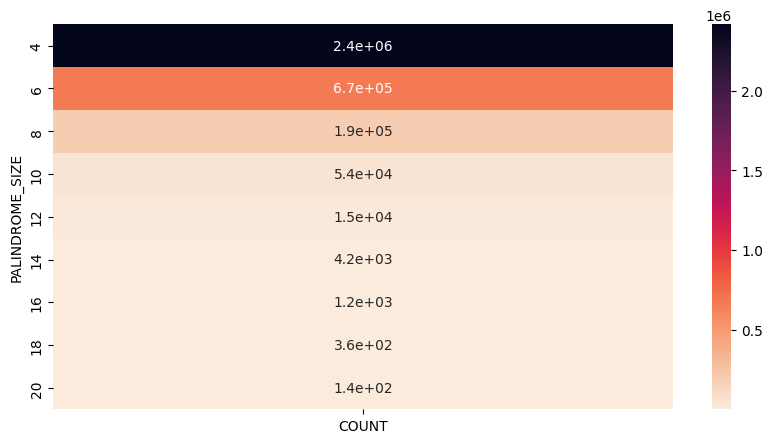

In [111]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(
    exome_palindrome.set_index(['PALINDROME_SIZE']),
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [114]:
# Similar trend as LSEQ RSEQ counts

### Hairpin

In [117]:
start=time.time()

#palindrome_d, count_d = palindrome([exome_seq.upper()], '')

# call hairpin() function with list of lseqs's to determine if there is a hairpin loop of size 4-8
hairpin_matrix = [get_metrics.hairpin([exome_seq.upper()], i) for i in range(4,9)]

end=time.time()
print(f'Run Time: {(end-start)/60} min')

Run Time: 20.733391189575194 min


In [118]:
hairpin_matrix

[[True], [True], [True], [True], [True]]

In [41]:
hairpin_matrix = [[True], [True], [True], [True], [True]]

In [42]:
transposed_matrix = np.transpose(hairpin_matrix)

In [43]:
loop_sizes = [[i+4 for i,col in enumerate(sub_list) if col == True] for sub_list in transposed_matrix]

In [44]:
loop_sizes

[[4, 5, 6, 7, 8]]

In [ ]:
loop_sizes

In [45]:
max_loop = [max(loop_values) if len(loop_values) > 0 else 0 for loop_values in loop_sizes]

In [46]:
max_loop

[8]

In [54]:
def hairpin(dna_list, loop_size = 4):
    """Takes a list of DNA sequences and an integer for loop_size.  Optimal loop_size is between 4 and 8.
       Determines if each sequence contains a hairpin loop or not. If flanking regions of the loop are 
       reverse complement of eachother, then it folds back on itself to form a hairpin loop. This portion
       is called the stem.  
    """
    # hairpin loop: ---stem1---loop---stem2---
   
    # all possible stem lengths
    stem_lengths = [4,5,6,7,8]
    hairpin_list = []  # list of boolean values shows if each sequence has a hairpin loop or not
    
    for seq in dna_list:
        # contains the sequence of the loop if a hairpin is formed
        loop_list = []
        for stem_length in stem_lengths:      
            count = 0
            # Any sequence of length L will contain (L - k + 1) total k-mers
            # treat the stem1---loop---stem2 unit as the 'kmer' 
            kmer_size = stem_length*2 + loop_size
            
            for i in range(len(seq)-kmer_size+1):  # (L - k + 1)
                kmer = seq[i:i+kmer_size]
                stem1 = kmer[:stem_length]
                loop = kmer[stem_length:stem_length+loop_size]
                stem2 = kmer[len(kmer)-stem_length:]
                count += 1
                #print(stem1,loop,stem2)
                # if reverse complement of stem1 == stem2 then it is a haripin because it will fold back on itself
                if complement(stem1)[::-1] == stem2:
                    loop_list.append(loop)
                    
            #print(count)
            #print(loop_list) 
           
        if len(loop_list) > 0:
            hairpin_list.append(True)
        else:
            hairpin_list.append(False)            
        
    return len(loop_list) #hairpin_list

In [55]:
start=time.time()

#palindrome_d, count_d = palindrome([exome_seq.upper()], '')

# call hairpin() function with list of lseqs's to determine if there is a hairpin loop of size 4-8
loop_list = [hairpin([exome_seq.upper()], i) for i in range(4,9)]

end=time.time()
print(f'Run Time: {(end-start)/60} min')

Run Time: 21.267672526836396 min


In [51]:
hairpin_matrix

[True]

In [56]:
len(loop_list)

5

In [ ]:
# len(loop_list) should be 5 for loop sizes 4,5,6,7,8
# len(loop_list[0]) is for loop 4, should be 353519

In [57]:
loop_list #[353519, 350458, 349975, 351573, 364089]

[353519, 350458, 349975, 351573, 364089]

In [58]:
exome_hairpin = pd.DataFrame({'HAIRPIN-LOOP_SIZE':[i for i in range(4,9)],
                              'COUNT':loop_list})

exome_hairpin.head()

,HAIRPIN-LOOP_SIZE,COUNT
0,4,353519
1,5,350458
2,6,349975
3,7,351573
4,8,364089


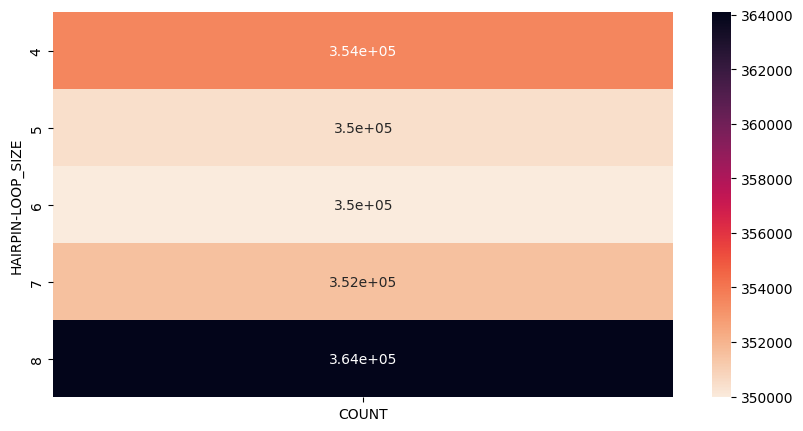

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(
    exome_hairpin.set_index(['HAIRPIN-LOOP_SIZE']),
    annot=True,
    fmt=".3g",
    cmap="rocket_r"
)
plt.show()

In [ ]:
# Most prevalent are loop sizes 8,4 where as in flanks it was 4,5,7